In [1]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np

from matplotlib import pyplot as plt
from matplotlib_venn import venn3

import statsmodels.api as sm

import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Read data

In [2]:
df = pd.read_parquet('/Users/julianeoliveira/Downloads/aesop_2025_11_10_mun_withMEM.parquet')

In [3]:
data = df.copy()

#[['co_ibge','nm_municipio','epiyear','year_week','atend_ivas','Aviso AESOP', 'sinal_ens_ivas','mem_surge',
#       'mem_surge_01','sinal_evi_ivas','sinal_ears_ivas','sinal_mmaing_ivas','mem_surge_01_without_isolated',
#        'mem_surge_01_corect_with_consec',
#       'warning_final_mem_surge_01']]

In [4]:
data = data[data.year_week >= '2022-42']

# Study an ensamble definition

In [5]:
code = 355030

set_muni = data[data.co_ibge == code]

In [6]:
set_muni = set_muni.assign( sinal_evi_ivas_lag_1 = set_muni['sinal_evi_ivas'].shift(1).fillna(0).astype(int),
                            sinal_evi_ivas_lag_2 = set_muni['sinal_evi_ivas'].shift(2).fillna(0).astype(int),
                            sinal_evi_ivas_lag_3 = set_muni['sinal_evi_ivas'].shift(3).fillna(0).astype(int),
                            sinal_ears_ivas_lag_1 = set_muni['sinal_ears_ivas'].shift(1).fillna(0).astype(int),
                            sinal_ears_ivas_lag_2 = set_muni['sinal_ears_ivas'].shift(2).fillna(0).astype(int),
                            sinal_ears_ivas_lag_3 = set_muni['sinal_ears_ivas'].shift(3).fillna(0).astype(int),
                            sinal_mmaing_ivas_lag_1 = set_muni['sinal_mmaing_ivas'].shift(1).fillna(0).astype(int),
                            sinal_mmaing_ivas_lag_2 = set_muni['sinal_mmaing_ivas'].shift(2).fillna(0).astype(int),
                            sinal_mmaing_ivas_lag_3 = set_muni['sinal_mmaing_ivas'].shift(3).fillna(0).astype(int),
                            mem_surge_01_lag_1 = set_muni['warning_final_mem_surge_01'].shift(-1).fillna(0).astype(int),
                            mem_surge_01_lag_2 = set_muni['warning_final_mem_surge_01'].shift(-2).fillna(0).astype(int),
                            mem_surge_01_lag_3 = set_muni['warning_final_mem_surge_01'].shift(-3).fillna(0).astype(int),
                            )

In [7]:
# --- Function to detect consecutive warnings in 4-week window ---
def detect_consecutive_events(subdf):
    subdf = subdf.sort_values("year_week").reset_index(drop=True)
    
    warnings = (subdf[["sinal_ears_ivas","sinal_evi_ivas","sinal_mmaing_ivas"]]
                .sum(axis=1))  # total warnings per week
    
    event_flags = []
    for i in range(len(warnings)):
        # look back 3 weeks (window of 4)
        window = warnings[max(0,i-3):i+1]
        # if at least 2+ models triggered in that window, flag it
        if (subdf.loc[max(0,i-3):i, ["sinal_ears_ivas","sinal_evi_ivas","sinal_mmaing_ivas"]].sum().gt(0).sum() >= 2):
            event_flags.append(1)
        else:
            event_flags.append(0)
    
    subdf["consecutive_event"] = event_flags
    return subdf

In [8]:
# --- Apply per municipality ---
set_muni = set_muni.groupby("co_ibge").apply(detect_consecutive_events).reset_index(drop=True)

# using the three models without lag

In [9]:
set_muni[['sinal_evi_ivas', 'sinal_ears_ivas',
       'sinal_mmaing_ivas','mem_surge_01']].sum()

sinal_evi_ivas       14.0
sinal_ears_ivas      19.0
sinal_mmaing_ivas    18.0
mem_surge_01         24.0
dtype: float64

In [10]:
# Split dataset
X = set_muni[['sinal_evi_ivas', 'sinal_ears_ivas',
       'sinal_mmaing_ivas']].fillna(0) 

y = set_muni['mem_surge_01']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=500)

# Fit model
clf = LogisticRegression(class_weight="balanced")
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      0.83      0.91         6

    accuracy                           0.97        32
   macro avg       0.98      0.92      0.95        32
weighted avg       0.97      0.97      0.97        32



In [11]:
# To get risk probabilities
risk_probs = clf.predict_proba(X_test)[:, 1]

In [12]:
set_muni = set_muni.assign(risk_probs = clf.predict_proba(X)[:, 1])

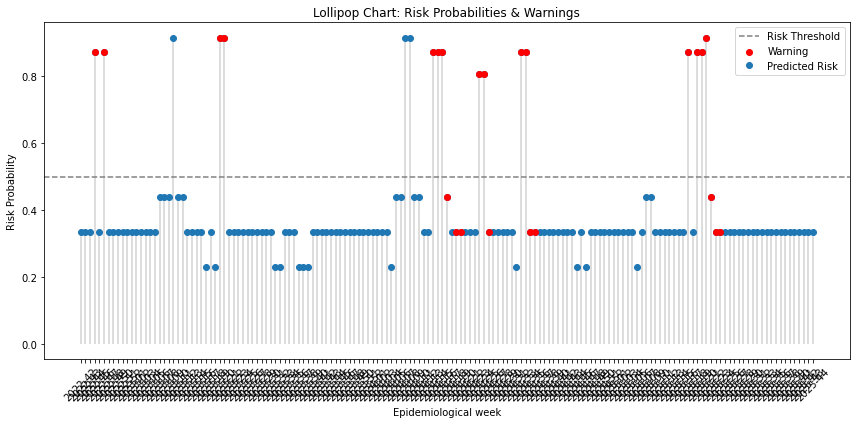

In [13]:
plt.figure(figsize=(12, 6))
plt.stem(set_muni['year_week'], set_muni['risk_probs'],
         basefmt=" ", linefmt='lightgray', markerfmt='o', label='Predicted Risk')

plt.scatter(set_muni.loc[set_muni['mem_surge_01'] == 1, 'year_week'],
            set_muni.loc[set_muni['mem_surge_01'] == 1, 'risk_probs'],
            color='red', label='Warning', zorder=3)

plt.axhline(0.5, color='gray', linestyle='--', label='Risk Threshold')
plt.xticks(rotation=45)
plt.title('Lollipop Chart: Risk Probabilities & Warnings')
plt.xlabel('Epidemiological week')
plt.ylabel('Risk Probability')
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()


In [14]:
set_muni = set_muni.assign(aviso_aesop = (set_muni["risk_probs"] > 0.5).astype(int))


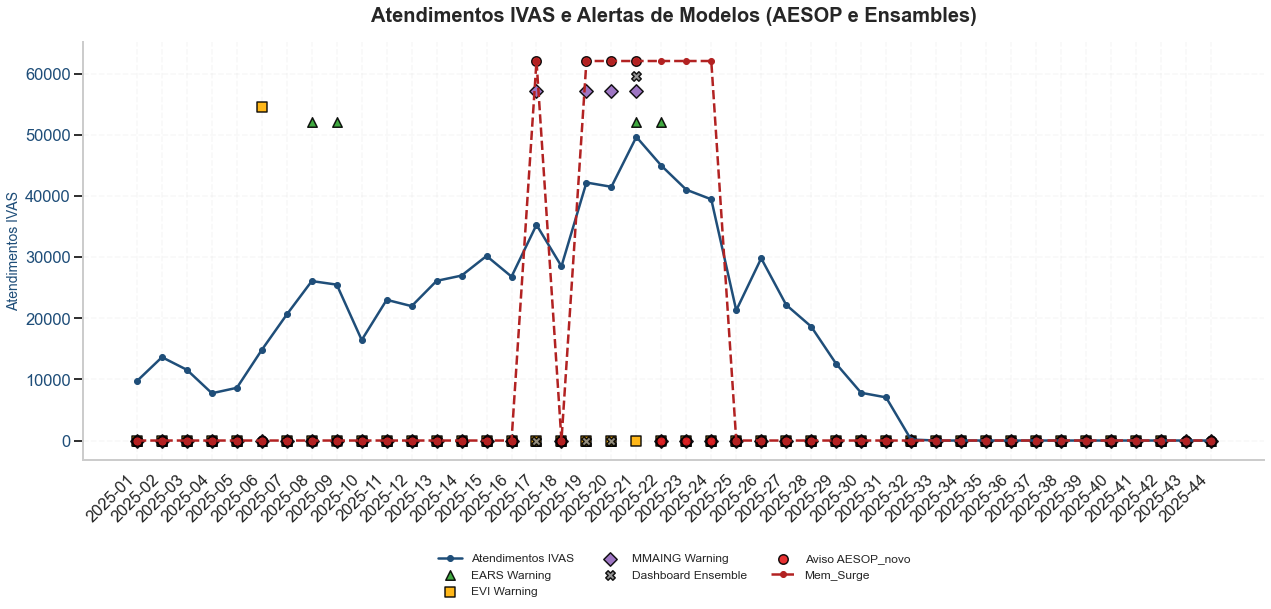

In [15]:
# --- Plot for one municipality ---
# muni = code
plotdf = set_muni[set_muni.year_week >= '2025-01'].copy()

# Clean and modern style
sns.set(style="whitegrid", context="talk")
sns.set_style("whitegrid", {"axes.grid": True, "grid.linestyle": "--", "grid.color": "0.9"})

fig, ax1 = plt.subplots(figsize=(18, 9))

# --- Main ILI line (Atend_ivas) ---
ax1.plot(
    plotdf["year_week"],
    plotdf["atend_ivas"],
    marker="o",
    color="#1f4e79",  # deep blue
    linewidth=2.5,
    markersize=6,
    label="Atendimentos IVAS"
)
ax1.set_ylabel("Atendimentos IVAS", color="#1f4e79", fontsize=14)
ax1.tick_params(axis="y", labelcolor="#1f4e79")

# --- Reduce x-axis clutter ---
ax1.set_xticks(plotdf["year_week"][::2])
ax1.set_xticklabels(plotdf["year_week"][::2], rotation=45, ha="right")

# --- Model warnings as markers ---
ymax = plotdf["atend_ivas"].max()

warnings = [
    ("sinal_ears_ivas",  1.05, "^", "#2ca02c", "EARS Warning"),       # green
    ("sinal_evi_ivas",   1.10, "s", "#ffb000", "EVI Warning"),       # amber-yellow
    ("sinal_mmaing_ivas",1.15, "D", "#9467bd", "MMAING Warning"),    # violet
    ("sinal_ens_ivas",   1.20, "X", "#8c8c8c", "Dashboard Ensemble"),# gray
    ("aviso_aesop",      1.25, "o", "#e41a1c", "Aviso AESOP_novo"),  # red
]

for col, mult, mark, colr, label in warnings:
    ax1.scatter(
        plotdf["year_week"],
        plotdf[col] * ymax * mult,
        marker=mark,
        color=colr,
        edgecolor="black",  # subtle outline for contrast
        s=90,
        alpha=0.9,
        label=label
    )

# --- Secondary axis: Mem_Surge (silent axis) ---
ax2 = ax1.twinx()
ax2.plot(
    plotdf["year_week"],
    plotdf["mem_surge_01"].astype(int),
    color="#b22222",        # deep red
    linestyle="--",
    linewidth=2.5,
    marker="o",
    markersize=6,
    label="Mem_Surge"
)

# Make secondary axis silent
ax2.set_yticks([])
ax2.set_ylabel("")
ax2.tick_params(axis="y", which="both", left=False, right=False, labelleft=False, labelright=False)
ax2.spines["right"].set_visible(False)

# --- Title and Legend ---
plt.title(
    f"Atendimentos IVAS e Alertas de Modelos (AESOP e Ensambles)",
    fontsize=20, weight="bold", pad=20
)

# Combine legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    handles1 + handles2, labels1 + labels2,
    loc="upper center", bbox_to_anchor=(0.5, -0.2),
    ncol=3, frameon=False, fontsize=12
)

# --- Final touches ---
ax1.grid(True, which="major", linestyle="--", alpha=0.3)
ax1.grid(False, which="minor")
fig.tight_layout()
sns.despine(left=False, right=True)

plt.show()


# all with lag

In [17]:
# Split dataset
X = set_muni[['sinal_evi_ivas', 'sinal_evi_ivas_lag_1', 'sinal_evi_ivas_lag_2', 'sinal_evi_ivas_lag_3',
              'sinal_ears_ivas', 'sinal_ears_ivas_lag_1', 'sinal_ears_ivas_lag_2', 'sinal_ears_ivas_lag_3',
              'sinal_mmaing_ivas', 'sinal_mmaing_ivas_lag_1', 'sinal_mmaing_ivas_lag_2', 'sinal_mmaing_ivas_lag_3']].fillna(0) 

y = set_muni['mem_surge_01']#'mem_surge_01_corect_with_consec']#

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=500)

# Fit model
clf = LogisticRegression(fit_intercept=False,class_weight="balanced")
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.85      0.90        26
           1       0.56      0.83      0.67         6

    accuracy                           0.84        32
   macro avg       0.76      0.84      0.78        32
weighted avg       0.88      0.84      0.85        32



In [18]:
set_muni = set_muni.assign(risk_probs = clf.predict_proba(X)[:, 1])

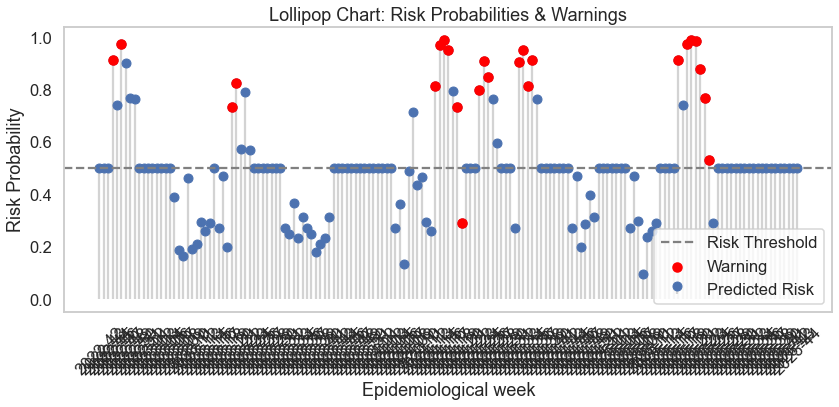

In [19]:
plt.figure(figsize=(12, 6))
plt.stem(set_muni['year_week'], set_muni['risk_probs'],
         basefmt=" ", linefmt='lightgray', markerfmt='o', label='Predicted Risk')

plt.scatter(set_muni.loc[set_muni['mem_surge_01'] == 1, 'year_week'],
            set_muni.loc[set_muni['mem_surge_01'] == 1, 'risk_probs'],
            color='red', label='Warning', zorder=3)

plt.axhline(0.5, color='gray', linestyle='--', label='Risk Threshold')
plt.xticks(rotation=45)
plt.title('Lollipop Chart: Risk Probabilities & Warnings')
plt.xlabel('Epidemiological week')
plt.ylabel('Risk Probability')
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()


In [20]:
set_muni = set_muni.assign(aviso_aesop = (set_muni["risk_probs"] > 0.5).astype(int))


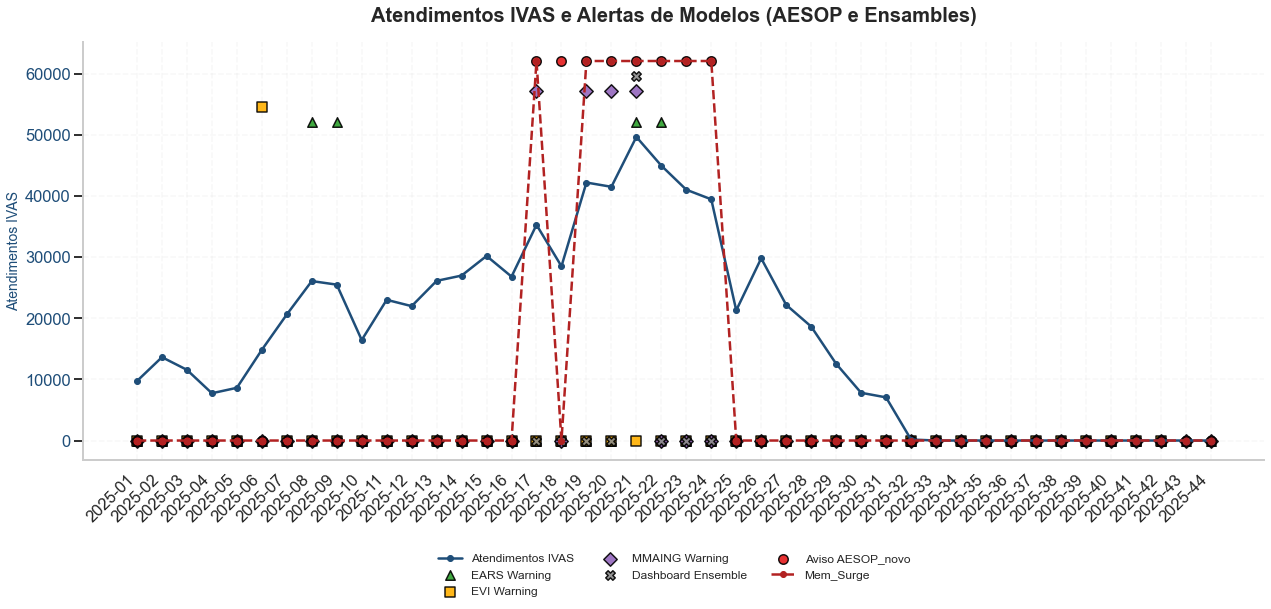

In [21]:
# --- Plot for one municipality ---
# muni = code
plotdf = set_muni[set_muni.year_week >= '2025-01'].copy()

# Clean and modern style
sns.set(style="whitegrid", context="talk")
sns.set_style("whitegrid", {"axes.grid": True, "grid.linestyle": "--", "grid.color": "0.9"})

fig, ax1 = plt.subplots(figsize=(18, 9))

# --- Main ILI line (Atend_ivas) ---
ax1.plot(
    plotdf["year_week"],
    plotdf["atend_ivas"],
    marker="o",
    color="#1f4e79",  # deep blue
    linewidth=2.5,
    markersize=6,
    label="Atendimentos IVAS"
)
ax1.set_ylabel("Atendimentos IVAS", color="#1f4e79", fontsize=14)
ax1.tick_params(axis="y", labelcolor="#1f4e79")

# --- Reduce x-axis clutter ---
ax1.set_xticks(plotdf["year_week"][::2])
ax1.set_xticklabels(plotdf["year_week"][::2], rotation=45, ha="right")

# --- Model warnings as markers ---
ymax = plotdf["atend_ivas"].max()

warnings = [
    ("sinal_ears_ivas",  1.05, "^", "#2ca02c", "EARS Warning"),       # green
    ("sinal_evi_ivas",   1.10, "s", "#ffb000", "EVI Warning"),       # amber-yellow
    ("sinal_mmaing_ivas",1.15, "D", "#9467bd", "MMAING Warning"),    # violet
    ("sinal_ens_ivas",   1.20, "X", "#8c8c8c", "Dashboard Ensemble"),# gray
    ("aviso_aesop",      1.25, "o", "#e41a1c", "Aviso AESOP_novo"),  # red
]

for col, mult, mark, colr, label in warnings:
    ax1.scatter(
        plotdf["year_week"],
        plotdf[col] * ymax * mult,
        marker=mark,
        color=colr,
        edgecolor="black",  # subtle outline for contrast
        s=90,
        alpha=0.9,
        label=label
    )

# --- Secondary axis: Mem_Surge (silent axis) ---
ax2 = ax1.twinx()
ax2.plot(
    plotdf["year_week"],
    plotdf["mem_surge_01"].astype(int),
    color="#b22222",        # deep red
    linestyle="--",
    linewidth=2.5,
    marker="o",
    markersize=6,
    label="Mem_Surge"
)

# Make secondary axis silent
ax2.set_yticks([])
ax2.set_ylabel("")
ax2.tick_params(axis="y", which="both", left=False, right=False, labelleft=False, labelright=False)
ax2.spines["right"].set_visible(False)

# --- Title and Legend ---
plt.title(
    f"Atendimentos IVAS e Alertas de Modelos (AESOP e Ensambles)",
    fontsize=20, weight="bold", pad=20
)

# Combine legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    handles1 + handles2, labels1 + labels2,
    loc="upper center", bbox_to_anchor=(0.5, -0.2),
    ncol=3, frameon=False, fontsize=12
)

# --- Final touches ---
ax1.grid(True, which="major", linestyle="--", alpha=0.3)
ax1.grid(False, which="minor")
fig.tight_layout()
sns.despine(left=False, right=True)

plt.show()


# Unsupervised models

In [29]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# Example data
X = set_muni[['sinal_evi_ivas', 'sinal_evi_ivas_lag_1', 'sinal_evi_ivas_lag_2', 'sinal_evi_ivas_lag_3',
              'sinal_ears_ivas', 'sinal_ears_ivas_lag_1', 'sinal_ears_ivas_lag_2', 'sinal_ears_ivas_lag_3',
              'sinal_mmaing_ivas', 'sinal_mmaing_ivas_lag_1', 'sinal_mmaing_ivas_lag_2', 'sinal_mmaing_ivas_lag_3']].fillna(0) 
# Initialize models
iso_forest = IsolationForest(contamination=0.1, random_state=42)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
ocsvm = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

# Fit models
iso_scores = -iso_forest.fit(X).score_samples(X)
lof_scores = -lof.fit_predict(X)
ocsvm.fit(X)
ocsvm_scores = -ocsvm.decision_function(X)

# Normalize scores
iso_scores = (iso_scores - iso_scores.min()) / (iso_scores.max() - iso_scores.min())
lof_scores = (lof_scores - lof_scores.min()) / (lof_scores.max() - lof_scores.min())
ocsvm_scores = (ocsvm_scores - ocsvm_scores.min()) / (ocsvm_scores.max() - ocsvm_scores.min())

# Average score
ensemble_scores = (iso_scores + lof_scores + ocsvm_scores) / 3
# Example thresholding
threshold = 0.5
anomalies = ensemble_scores > threshold

In [40]:
set_muni = set_muni.assign(ens_nonsup = anomalies.astype(int),
                           ensemble_scores_nonsup = ensemble_scores,
                           iso_scores = iso_scores,
                           lof_scores = lof_scores,
                           ocsvm_scores = ocsvm_scores)

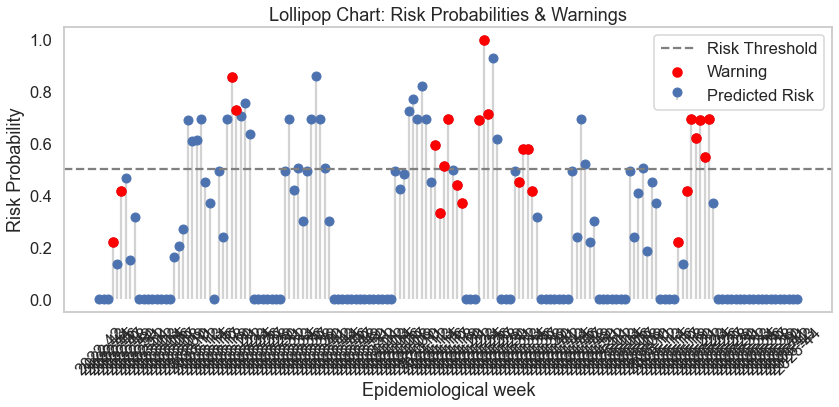

In [43]:
plt.figure(figsize=(12, 6))
plt.stem(set_muni['year_week'], set_muni['ocsvm_scores'],
         basefmt=" ", linefmt='lightgray', markerfmt='o', label='Predicted Risk')

plt.scatter(set_muni.loc[set_muni['mem_surge_01'] == 1, 'year_week'],
            set_muni.loc[set_muni['mem_surge_01'] == 1, 'ocsvm_scores'],
            color='red', label='Warning', zorder=3)

plt.axhline(0.5, color='gray', linestyle='--', label='Risk Threshold')
plt.xticks(rotation=45)
plt.title('Lollipop Chart: Risk Probabilities & Warnings')
plt.xlabel('Epidemiological week')
plt.ylabel('Risk Probability')
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()


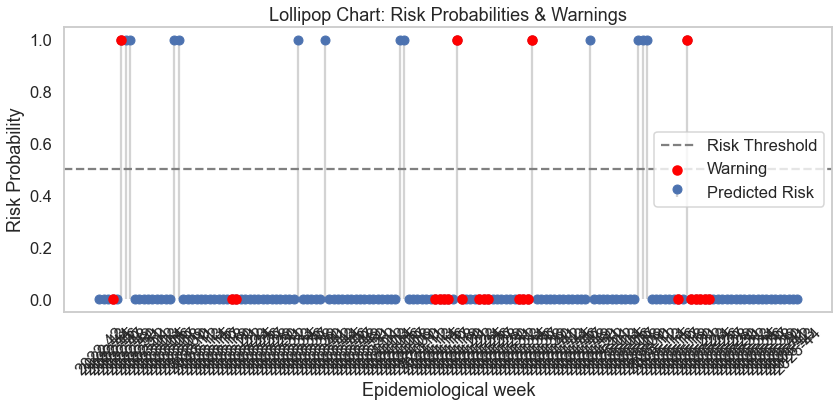

In [42]:
plt.figure(figsize=(12, 6))
plt.stem(set_muni['year_week'], set_muni['lof_scores'],
         basefmt=" ", linefmt='lightgray', markerfmt='o', label='Predicted Risk')

plt.scatter(set_muni.loc[set_muni['mem_surge_01'] == 1, 'year_week'],
            set_muni.loc[set_muni['mem_surge_01'] == 1, 'lof_scores'],
            color='red', label='Warning', zorder=3)

plt.axhline(0.5, color='gray', linestyle='--', label='Risk Threshold')
plt.xticks(rotation=45)
plt.title('Lollipop Chart: Risk Probabilities & Warnings')
plt.xlabel('Epidemiological week')
plt.ylabel('Risk Probability')
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()


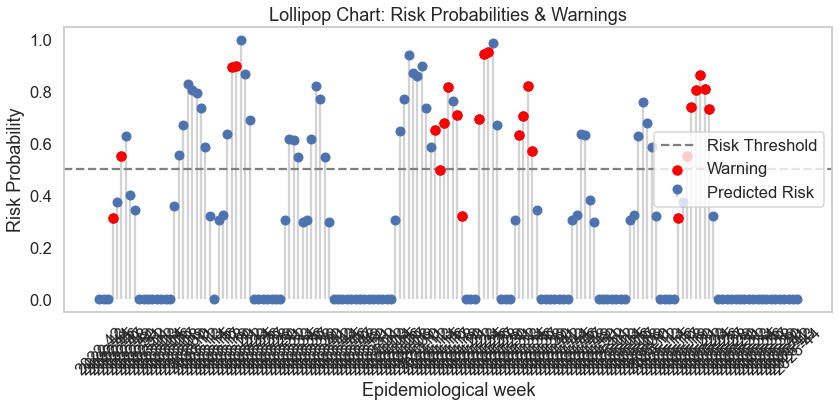

In [41]:
plt.figure(figsize=(12, 6))
plt.stem(set_muni['year_week'], set_muni['iso_scores'],
         basefmt=" ", linefmt='lightgray', markerfmt='o', label='Predicted Risk')

plt.scatter(set_muni.loc[set_muni['mem_surge_01'] == 1, 'year_week'],
            set_muni.loc[set_muni['mem_surge_01'] == 1, 'iso_scores'],
            color='red', label='Warning', zorder=3)

plt.axhline(0.5, color='gray', linestyle='--', label='Risk Threshold')
plt.xticks(rotation=45)
plt.title('Lollipop Chart: Risk Probabilities & Warnings')
plt.xlabel('Epidemiological week')
plt.ylabel('Risk Probability')
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()


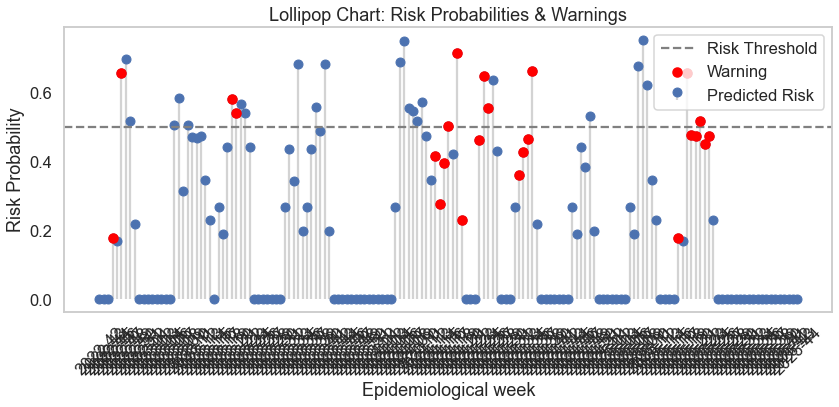

In [38]:
plt.figure(figsize=(12, 6))
plt.stem(set_muni['year_week'], set_muni['ensemble_scores_nonsup'],
         basefmt=" ", linefmt='lightgray', markerfmt='o', label='Predicted Risk')

plt.scatter(set_muni.loc[set_muni['mem_surge_01'] == 1, 'year_week'],
            set_muni.loc[set_muni['mem_surge_01'] == 1, 'ensemble_scores_nonsup'],
            color='red', label='Warning', zorder=3)

plt.axhline(0.5, color='gray', linestyle='--', label='Risk Threshold')
plt.xticks(rotation=45)
plt.title('Lollipop Chart: Risk Probabilities & Warnings')
plt.xlabel('Epidemiological week')
plt.ylabel('Risk Probability')
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()


In [45]:
set_muni = set_muni.assign(ens_ocsvm = (set_muni["ocsvm_scores"] > 0.5).astype(int))


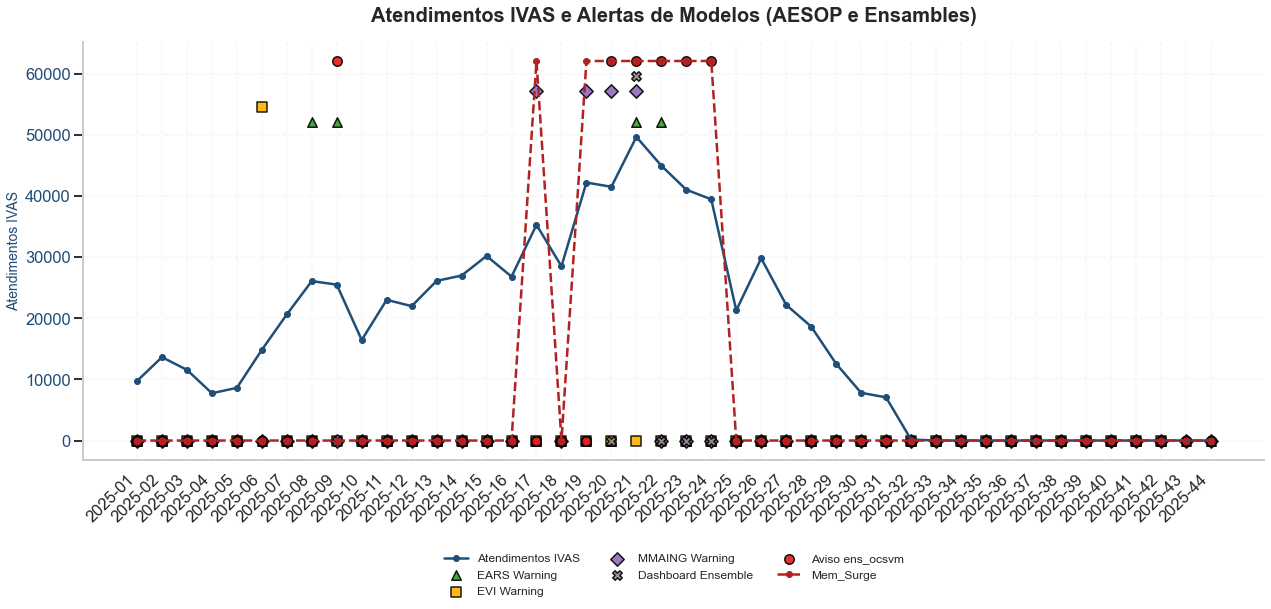

In [47]:
# --- Plot for one municipality ---
# muni = code
plotdf = set_muni[set_muni.year_week >= '2025-01'].copy()

# Clean and modern style
sns.set(style="whitegrid", context="talk")
sns.set_style("whitegrid", {"axes.grid": True, "grid.linestyle": "--", "grid.color": "0.9"})

fig, ax1 = plt.subplots(figsize=(18, 9))

# --- Main ILI line (Atend_ivas) ---
ax1.plot(
    plotdf["year_week"],
    plotdf["atend_ivas"],
    marker="o",
    color="#1f4e79",  # deep blue
    linewidth=2.5,
    markersize=6,
    label="Atendimentos IVAS"
)
ax1.set_ylabel("Atendimentos IVAS", color="#1f4e79", fontsize=14)
ax1.tick_params(axis="y", labelcolor="#1f4e79")

# --- Reduce x-axis clutter ---
ax1.set_xticks(plotdf["year_week"][::2])
ax1.set_xticklabels(plotdf["year_week"][::2], rotation=45, ha="right")

# --- Model warnings as markers ---
ymax = plotdf["atend_ivas"].max()

warnings = [
    ("sinal_ears_ivas",  1.05, "^", "#2ca02c", "EARS Warning"),       # green
    ("sinal_evi_ivas",   1.10, "s", "#ffb000", "EVI Warning"),       # amber-yellow
    ("sinal_mmaing_ivas",1.15, "D", "#9467bd", "MMAING Warning"),    # violet
    ("sinal_ens_ivas",   1.20, "X", "#8c8c8c", "Dashboard Ensemble"),# gray
    ("ens_ocsvm",      1.25, "o", "#e41a1c", "Aviso ens_ocsvm"),  # red
]

for col, mult, mark, colr, label in warnings:
    ax1.scatter(
        plotdf["year_week"],
        plotdf[col] * ymax * mult,
        marker=mark,
        color=colr,
        edgecolor="black",  # subtle outline for contrast
        s=90,
        alpha=0.9,
        label=label
    )

# --- Secondary axis: Mem_Surge (silent axis) ---
ax2 = ax1.twinx()
ax2.plot(
    plotdf["year_week"],
    plotdf["mem_surge_01"].astype(int),
    color="#b22222",        # deep red
    linestyle="--",
    linewidth=2.5,
    marker="o",
    markersize=6,
    label="Mem_Surge"
)

# Make secondary axis silent
ax2.set_yticks([])
ax2.set_ylabel("")
ax2.tick_params(axis="y", which="both", left=False, right=False, labelleft=False, labelright=False)
ax2.spines["right"].set_visible(False)

# --- Title and Legend ---
plt.title(
    f"Atendimentos IVAS e Alertas de Modelos (AESOP e Ensambles)",
    fontsize=20, weight="bold", pad=20
)

# Combine legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    handles1 + handles2, labels1 + labels2,
    loc="upper center", bbox_to_anchor=(0.5, -0.2),
    ncol=3, frameon=False, fontsize=12
)

# --- Final touches ---
ax1.grid(True, which="major", linestyle="--", alpha=0.3)
ax1.grid(False, which="minor")
fig.tight_layout()
sns.despine(left=False, right=True)

plt.show()


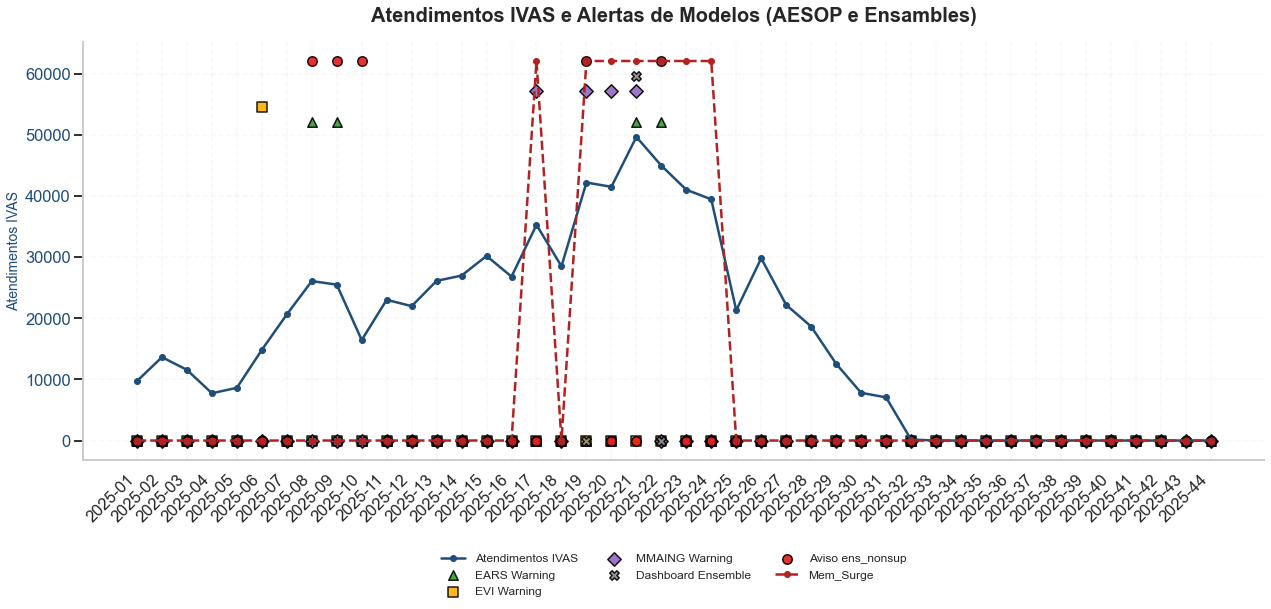

In [49]:
# --- Plot for one municipality ---
# muni = code
plotdf = set_muni[set_muni.year_week >= '2025-01'].copy()

# Clean and modern style
sns.set(style="whitegrid", context="talk")
sns.set_style("whitegrid", {"axes.grid": True, "grid.linestyle": "--", "grid.color": "0.9"})

fig, ax1 = plt.subplots(figsize=(18, 9))

# --- Main ILI line (Atend_ivas) ---
ax1.plot(
    plotdf["year_week"],
    plotdf["atend_ivas"],
    marker="o",
    color="#1f4e79",  # deep blue
    linewidth=2.5,
    markersize=6,
    label="Atendimentos IVAS"
)
ax1.set_ylabel("Atendimentos IVAS", color="#1f4e79", fontsize=14)
ax1.tick_params(axis="y", labelcolor="#1f4e79")

# --- Reduce x-axis clutter ---
ax1.set_xticks(plotdf["year_week"][::2])
ax1.set_xticklabels(plotdf["year_week"][::2], rotation=45, ha="right")

# --- Model warnings as markers ---
ymax = plotdf["atend_ivas"].max()

warnings = [
    ("sinal_ears_ivas",  1.05, "^", "#2ca02c", "EARS Warning"),       # green
    ("sinal_evi_ivas",   1.10, "s", "#ffb000", "EVI Warning"),       # amber-yellow
    ("sinal_mmaing_ivas",1.15, "D", "#9467bd", "MMAING Warning"),    # violet
    ("sinal_ens_ivas",   1.20, "X", "#8c8c8c", "Dashboard Ensemble"),# gray
    ("ens_nonsup",      1.25, "o", "#e41a1c", "Aviso ens_nonsup"),  # red
]

for col, mult, mark, colr, label in warnings:
    ax1.scatter(
        plotdf["year_week"],
        plotdf[col] * ymax * mult,
        marker=mark,
        color=colr,
        edgecolor="black",  # subtle outline for contrast
        s=90,
        alpha=0.9,
        label=label
    )

# --- Secondary axis: Mem_Surge (silent axis) ---
ax2 = ax1.twinx()
ax2.plot(
    plotdf["year_week"],
    plotdf["mem_surge_01"].astype(int),
    color="#b22222",        # deep red
    linestyle="--",
    linewidth=2.5,
    marker="o",
    markersize=6,
    label="Mem_Surge"
)

# Make secondary axis silent
ax2.set_yticks([])
ax2.set_ylabel("")
ax2.tick_params(axis="y", which="both", left=False, right=False, labelleft=False, labelright=False)
ax2.spines["right"].set_visible(False)

# --- Title and Legend ---
plt.title(
    f"Atendimentos IVAS e Alertas de Modelos (AESOP e Ensambles)",
    fontsize=20, weight="bold", pad=20
)

# Combine legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    handles1 + handles2, labels1 + labels2,
    loc="upper center", bbox_to_anchor=(0.5, -0.2),
    ncol=3, frameon=False, fontsize=12
)

# --- Final touches ---
ax1.grid(True, which="major", linestyle="--", alpha=0.3)
ax1.grid(False, which="minor")
fig.tight_layout()
sns.despine(left=False, right=True)

plt.show()


In [50]:
set_muni = set_muni.assign(ens_iso = (set_muni["iso_scores"] > 0.5).astype(int))


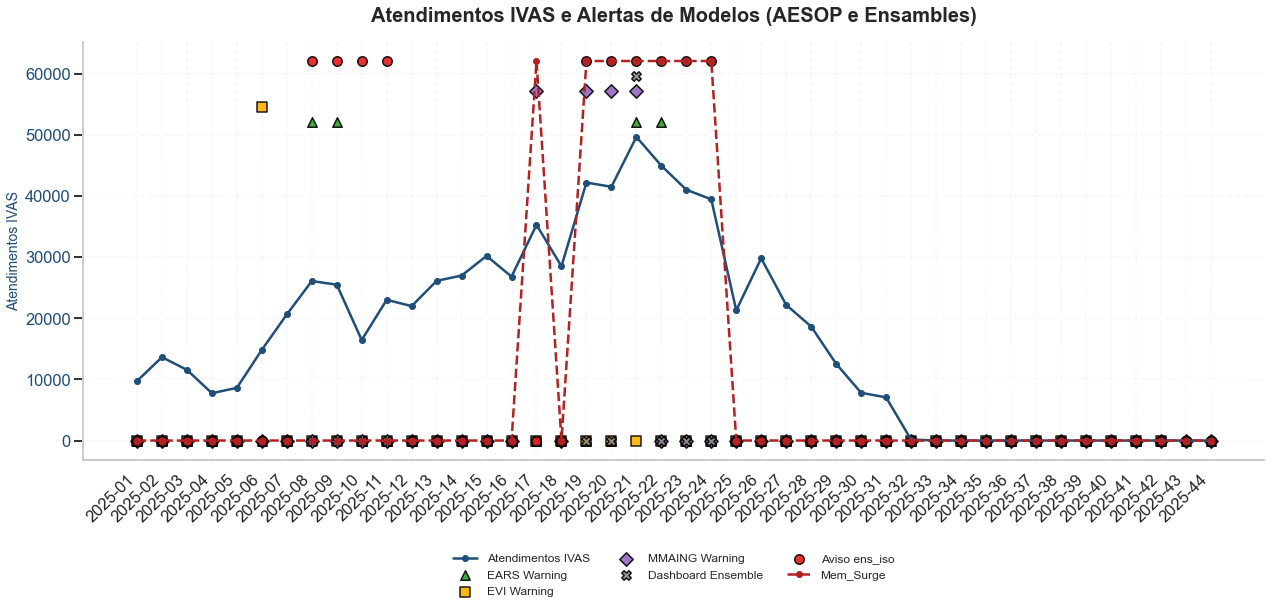

In [51]:
# --- Plot for one municipality ---
# muni = code
plotdf = set_muni[set_muni.year_week >= '2025-01'].copy()

# Clean and modern style
sns.set(style="whitegrid", context="talk")
sns.set_style("whitegrid", {"axes.grid": True, "grid.linestyle": "--", "grid.color": "0.9"})

fig, ax1 = plt.subplots(figsize=(18, 9))

# --- Main ILI line (Atend_ivas) ---
ax1.plot(
    plotdf["year_week"],
    plotdf["atend_ivas"],
    marker="o",
    color="#1f4e79",  # deep blue
    linewidth=2.5,
    markersize=6,
    label="Atendimentos IVAS"
)
ax1.set_ylabel("Atendimentos IVAS", color="#1f4e79", fontsize=14)
ax1.tick_params(axis="y", labelcolor="#1f4e79")

# --- Reduce x-axis clutter ---
ax1.set_xticks(plotdf["year_week"][::2])
ax1.set_xticklabels(plotdf["year_week"][::2], rotation=45, ha="right")

# --- Model warnings as markers ---
ymax = plotdf["atend_ivas"].max()

warnings = [
    ("sinal_ears_ivas",  1.05, "^", "#2ca02c", "EARS Warning"),       # green
    ("sinal_evi_ivas",   1.10, "s", "#ffb000", "EVI Warning"),       # amber-yellow
    ("sinal_mmaing_ivas",1.15, "D", "#9467bd", "MMAING Warning"),    # violet
    ("sinal_ens_ivas",   1.20, "X", "#8c8c8c", "Dashboard Ensemble"),# gray
    ("ens_iso",      1.25, "o", "#e41a1c", "Aviso ens_iso"),  # red
]

for col, mult, mark, colr, label in warnings:
    ax1.scatter(
        plotdf["year_week"],
        plotdf[col] * ymax * mult,
        marker=mark,
        color=colr,
        edgecolor="black",  # subtle outline for contrast
        s=90,
        alpha=0.9,
        label=label
    )

# --- Secondary axis: Mem_Surge (silent axis) ---
ax2 = ax1.twinx()
ax2.plot(
    plotdf["year_week"],
    plotdf["mem_surge_01"].astype(int),
    color="#b22222",        # deep red
    linestyle="--",
    linewidth=2.5,
    marker="o",
    markersize=6,
    label="Mem_Surge"
)

# Make secondary axis silent
ax2.set_yticks([])
ax2.set_ylabel("")
ax2.tick_params(axis="y", which="both", left=False, right=False, labelleft=False, labelright=False)
ax2.spines["right"].set_visible(False)

# --- Title and Legend ---
plt.title(
    f"Atendimentos IVAS e Alertas de Modelos (AESOP e Ensambles)",
    fontsize=20, weight="bold", pad=20
)

# Combine legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    handles1 + handles2, labels1 + labels2,
    loc="upper center", bbox_to_anchor=(0.5, -0.2),
    ncol=3, frameon=False, fontsize=12
)

# --- Final touches ---
ax1.grid(True, which="major", linestyle="--", alpha=0.3)
ax1.grid(False, which="minor")
fig.tight_layout()
sns.despine(left=False, right=True)

plt.show()
